In [66]:
import os
# os.chdir(r"/content/drive/MyDrive/billing_features/raw/")
import math
import time
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import missingno as msno
import pickle
import lightgbm
import xgboost as xgb
#tuning hyperparameters
from bayes_opt import BayesianOptimization
from skopt  import BayesSearchCV 

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score,average_precision_score
from sklearn.metrics import precision_recall_fscore_support 
from sklearn.metrics import roc_curve,precision_recall_curve
from sklearn.metrics import auc as auc_score
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [67]:
file="policy_premium_pickle"
data_dir="/app/models/dij22"
policy_premium_df=pd.read_pickle(os.path.join(data_dir,file))

In [68]:
# data_dir="/app/models/trident/retention/engineered_update"
# churn_labels = pd.read_csv(os.path.join(data_dir,'churn_labels.csv'))
churn_labels = pd.read_csv(os.path.join(os.getcwd(),"churn_labels_update.csv"))
churn_labels.dropna(subset=['churn'],inplace=True)
# churn_labels['policy_id']=churn_labels['policy_id'].astype(int)
# churn_labels['year']=churn_labels['year'].apply(int)
# churn_labels.shape

In [134]:
positive_sample=churn_labels[churn_labels.churn==1]
check=0
for index,row in tqdm(positive_sample.iterrows(), total=positive_sample.shape[0]):
    if pd.to_datetime(row["policy_anniv_dt"])==pd.to_datetime(row["policy_term_dt"]):
        check+=1

print(f"Among all churn policy {positive_sample.shape[0]:,}, there are {check/positive_sample.shape[0]:.2%} data whose policy_anniv_dt==policy_term_dt")

100%|██████████| 48489/48489 [00:17<00:00, 2840.40it/s]

Among all churn policy 48,489, there are 38.17% data whose policy_anniv_dt==policy_term_dt


### Yearly Based Data
- every policy_id only has one observation in every year
- 

In [5]:
def data_merge_yearly(churn_df, policy_df, buffer):
    policy_id=[]
    policy_anniv_dt=[]
    orig_policy_eff_dt=[]
    policy_term_dt=[]
    year=[]
    month=[]
    pivot_date=[]
    survival_month=[]
    churn=[]
    for index,row in tqdm(churn_df.iterrows(), total=churn_df.shape[0]):           
            
        policy_term_month=pd.to_datetime(row["policy_term_dt"]).month
        policy_anniv_month=pd.to_datetime(row["policy_anniv_dt"]).month
        if np.isnan(policy_term_month):
            date1=str(row["year"])+str(int(policy_anniv_month))
        else:
            date1=str(row["year"])+str(int(policy_term_month))
        
        date2=pd.to_datetime(str(date1),format="%Y%m")-pd.offsets.DateOffset(months=buffer)

        policy_id.append(row["policy_id"])
        year.append(date2.year)
        month.append(date2.month)
        
        if int(date1[4:])<10:
            date1=date1[:4]+str(0)+date1[4:]
        pivot_date.append(date1)
        
        
        x2=pd.to_datetime(row["target_dt"])
        x1=pd.to_datetime(row["orig_policy_eff_dt"])
        survival_month.append(int((x2-x1)/np.timedelta64(1,"M")))
        
        policy_anniv_dt.append(row["policy_anniv_dt"])
        policy_term_dt.append(row["policy_term_dt"])
        orig_policy_eff_dt.append(row["orig_policy_eff_dt"])
        
        churn.append(row["churn"])
        
    churn_data=pd.DataFrame({"policy_id":policy_id,"orig_policy_eff_dt":orig_policy_eff_dt,"policy_anniv_dt":policy_anniv_dt,"policy_term_dt":policy_term_dt,
                             "pivot_date":pivot_date,"year":year,"month":month,"survival_month":survival_month,"churn":churn})
    # churn_data["month"]=output["month"].apply(lambda x: str(x) if x>=10 else str(0)+str(x))
    churn_data['policy_id']=churn_data['policy_id'].astype(int)
    churn_data['year']=churn_data['year'].apply(int)
    churn_data['month']=churn_data['month'].apply(int)
    
    df=pd.merge(churn_data,policy_df,how="inner", on=["policy_id", "year","month"])
    df.sort_values(by=["policy_id","year"],ascending=True,inplace=True)
    
    return df

In [6]:
df_buffer_0=data_merge_yearly(churn_labels,policy_premium_df, buffer=0)
df_buffer_1=data_merge_yearly(churn_labels,policy_premium_df, buffer=1)
df_buffer_2=data_merge_yearly(churn_labels,policy_premium_df, buffer=2)
df_buffer_3=data_merge_yearly(churn_labels,policy_premium_df, buffer=3)

100%|██████████| 445577/445577 [05:47<00:00, 1281.68it/s]


In [7]:
data_dir="/app/models/dij22"
df_buffer_0.to_pickle(os.path.join(data_dir,"df_buffer_0_pickle"))
df_buffer_1.to_pickle(os.path.join(data_dir,"df_buffer_1_pickle"))
df_buffer_2.to_pickle(os.path.join(data_dir,"df_buffer_2_pickle"))
df_buffer_3.to_pickle(os.path.join(data_dir,"df_buffer_3_pickle"))

In [2]:
data_dir="/app/models/dij22"
df_buffer_0=pd.read_pickle(os.path.join(data_dir,"df_buffer_0_pickle"))
df_buffer_1=pd.read_pickle(os.path.join(data_dir,"df_buffer_1_pickle"))
df_buffer_2=pd.read_pickle(os.path.join(data_dir,"df_buffer_2_pickle"))
df_buffer_3=pd.read_pickle(os.path.join(data_dir,"df_buffer_3_pickle"))

<Figure size 720x576 with 0 Axes>

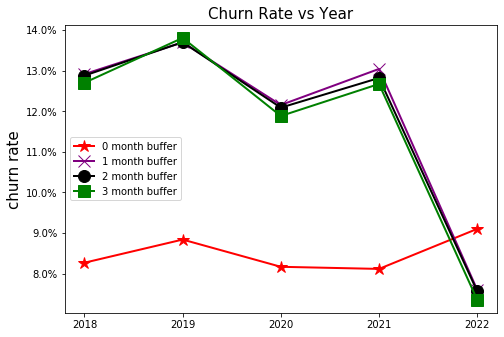

In [3]:
churn_year_0=df_buffer_0.groupby(['year']).mean().reset_index().loc[:,["year","churn"]]
churn_year_0.style.format({"churn":"{.2%}"})
churn_year_1=df_buffer_1.groupby(['year']).mean().reset_index().loc[:,["year","churn"]]
churn_year_1.style.format({"churn":"{.2%}"})
churn_year_2=df_buffer_2.groupby(['year']).mean().reset_index().loc[:,["year","churn"]]
churn_year_2.style.format({"churn":"{.2%}a"})
churn_year_3=df_buffer_3.groupby(['year']).mean().reset_index().loc[:,["year","churn"]]
churn_year_3.style.format({"churn":"{.2%}"})

plt.figure(figsize=(10,8))
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1]) # main axes

ax.plot(churn_year_0["year"],churn_year_0["churn"],color="r",marker="*",linewidth=2, markersize=12,label="0 month buffer")
ax.plot(churn_year_1["year"],churn_year_1["churn"],color="purple",marker="x",linewidth=2, markersize=12,label="1 month buffer")
ax.plot(churn_year_2["year"],churn_year_2["churn"],color="black",marker="o",linewidth=2, markersize=12,label="2 month buffer")
ax.plot(churn_year_3["year"],churn_year_3["churn"],color="green",marker="s",linewidth=2, markersize=12,label="3 month buffer")

ax.set_title("Churn Rate vs Year",fontsize=15)
ax.legend()
ax.set_ylabel("churn rate",fontsize=15)
ax.set_xticks([2018,2019,2020,2021,2022])
# ax.set_ylim([0,0.1])
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.1%}'.format(x) for x in vals])
plt.show()

In [29]:
temp0=df_buffer_0.groupby(['year','month'], as_index=False)["churn"].sum().rename(columns={"churn":"0 month buffer"})
temp1=df_buffer_1.groupby(['year','month'], as_index=False)["churn"].sum().rename(columns={"churn":"1 month buffer"})
temp2=df_buffer_2.groupby(['year','month'], as_index=False)["churn"].sum().rename(columns={"churn":"2 month buffer"})
temp3=df_buffer_3.groupby(['year','month'], as_index=False)["churn"].sum().rename(columns={"churn":"3 month buffer"})
temp=pd.merge(temp0,temp1,on=['year','month'],how="inner")
temp=pd.merge(temp,temp2,on=['year','month'],how="inner")
temp=pd.merge(temp,temp3,on=['year','month'],how="inner")
temp.style.format({"0 month buffer":"{:,}","1 month buffer":"{:,}","2 month buffer":"{:,}","3 month buffer":"{:,}"})\
    .set_caption("The number of churn occurence")\
    .set_table_styles([{
        'selector': 'caption',
        'props': [
            ('color', 'red'),
            ('font-size', '20px')
        ]
    }])

,year,month,0 month buffer,1 month buffer,2 month buffer,3 month buffer
0,2018,1,"1,682",450,505,574
1,2018,2,326,499,564,523
2,2018,3,388,563,521,620
3,2018,4,371,531,620,794
4,2018,5,399,621,782,451
5,2018,6,423,779,454,570
6,2018,7,575,465,580,608
7,2018,8,380,573,598,494
8,2018,9,402,595,496,696
9,2018,10,441,501,703,"2,850"


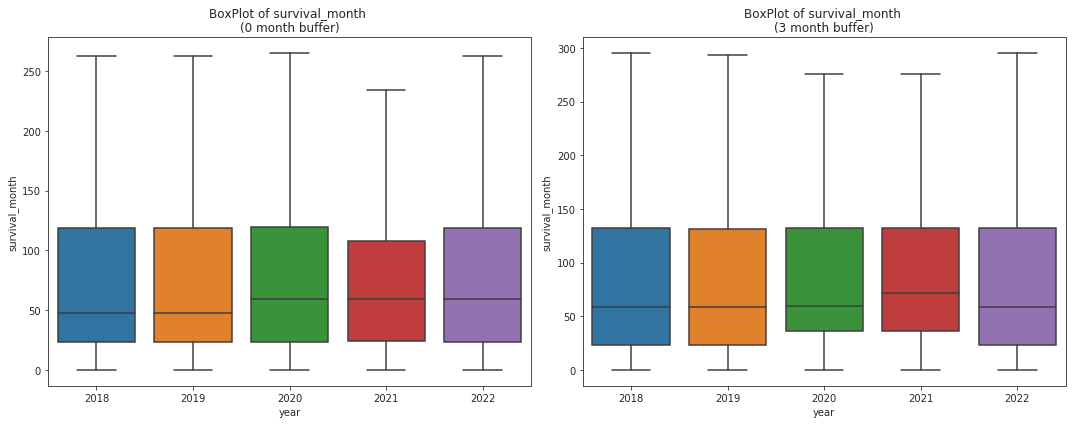

In [33]:
# plt.rcParams["figure.figsize"] = [10, 5]
# plt.rcParams["figure.autolayout"] = True
fig = plt.subplots(nrows=1,ncols=2,figsize =(15, 6))
plt.subplot(1, 2, 1)
# ax = sns.boxplot(data = df, x='year',y='policy_year', showfliers = dict(markerfacecolor = '0.50', markersize = 2))
ax = sns.boxplot(data = df_buffer_0, x='year',y='survival_month', showfliers = False)
# for item in ax.get_xticklabels():
#     item.set_rotation(90)
ax.set_title("BoxPlot of survival_month \n(0 month buffer)")

plt.subplot(1, 2, 2)
# ax = sns.boxplot(data = df, x='year',y='policy_year', showfliers = dict(markerfacecolor = '0.50', markersize = 2))
ax = sns.boxplot(data = df_buffer_3, x='year',y='survival_month', showfliers = False)
# for item in ax.get_xticklabels():
#     item.set_rotation(90)
ax.set_title("BoxPlot of survival_month \n(3 month buffer)")
plt.show()


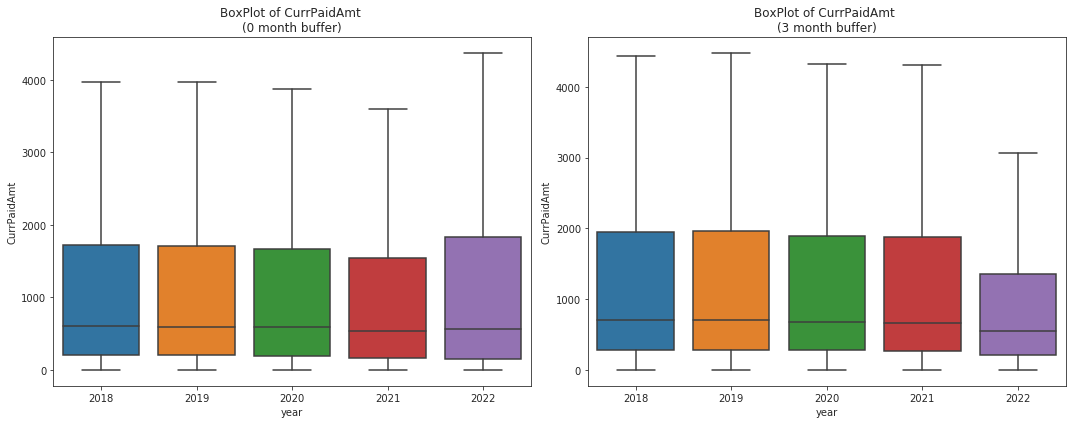

In [38]:
var="CurrPaidAmt"
# plt.rcParams["figure.figsize"] = [10, 5]
# plt.rcParams["figure.autolayout"] = True
fig = plt.subplots(nrows=1,ncols=2,figsize =(15, 6))
plt.subplot(1, 2, 1)
# ax = sns.boxplot(data = df, x='year',y='policy_year', showfliers = dict(markerfacecolor = '0.50', markersize = 2))
ax = sns.boxplot(data = df_buffer_0, x='year',y=var, showfliers = False)
# for item in ax.get_xticklabels():
#     item.set_rotation(90)
ax.set_title(f"BoxPlot of {var} \n(0 month buffer)")

plt.subplot(1, 2, 2)
# ax = sns.boxplot(data = df, x='year',y='policy_year', showfliers = dict(markerfacecolor = '0.50', markersize = 2))
ax = sns.boxplot(data = df_buffer_3, x='year',y=var, showfliers = False)
# for item in ax.get_xticklabels():
#     item.set_rotation(90)
ax.set_title(f"BoxPlot of {var} \n(3 month buffer)")
plt.show()


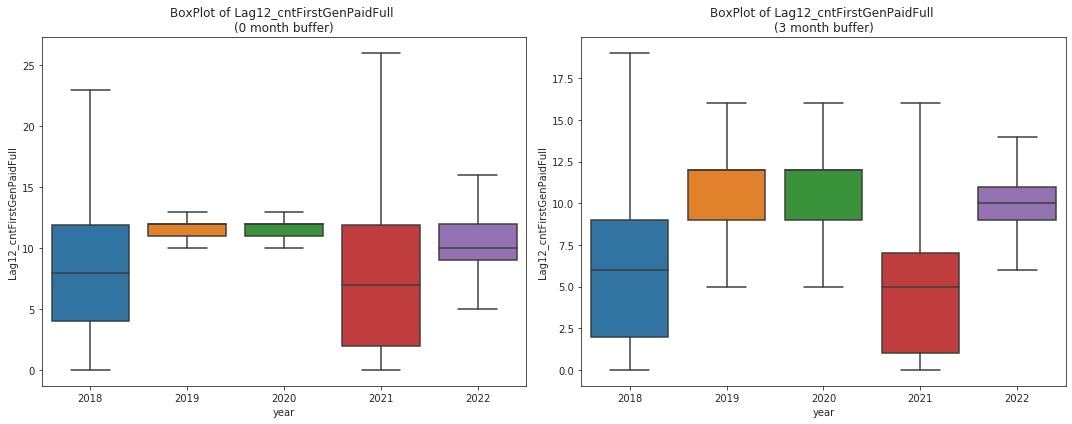

In [37]:
var="Lag12_cntFirstGenPaidFull"
# plt.rcParams["figure.figsize"] = [10, 5]
# plt.rcParams["figure.autolayout"] = True
fig = plt.subplots(nrows=1,ncols=2,figsize =(15, 6))
plt.subplot(1, 2, 1)
# ax = sns.boxplot(data = df, x='year',y='policy_year', showfliers = dict(markerfacecolor = '0.50', markersize = 2))
ax = sns.boxplot(data = df_buffer_0, x='year',y=var, showfliers = False)
# for item in ax.get_xticklabels():
#     item.set_rotation(90)
ax.set_title(f"BoxPlot of {var} \n(0 month buffer)")

plt.subplot(1, 2, 2)
# ax = sns.boxplot(data = df, x='year',y='policy_year', showfliers = dict(markerfacecolor = '0.50', markersize = 2))
ax = sns.boxplot(data = df_buffer_3, x='year',y=var, showfliers = False)
# for item in ax.get_xticklabels():
#     item.set_rotation(90)
ax.set_title(f"BoxPlot of {var} \n(3 month buffer)")
plt.show()

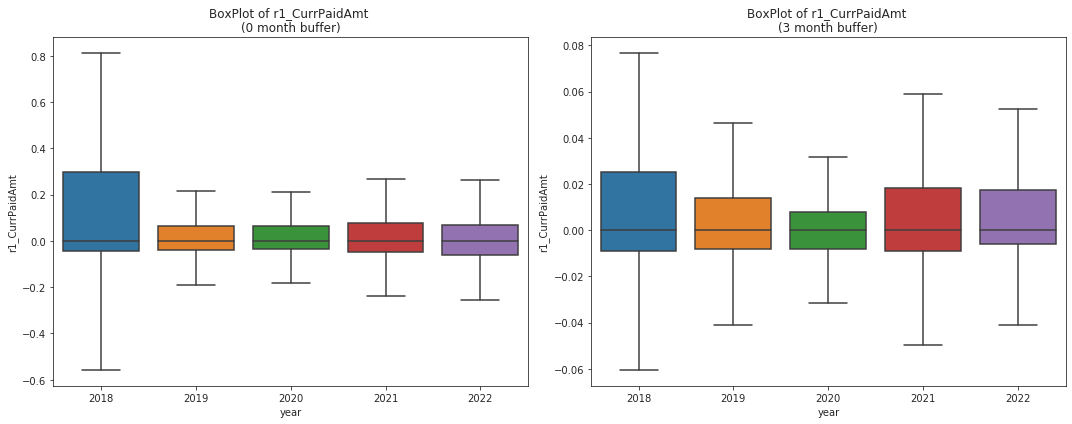

In [41]:
var="r1_CurrPaidAmt"
# plt.rcParams["figure.figsize"] = [10, 5]
# plt.rcParams["figure.autolayout"] = True
fig = plt.subplots(nrows=1,ncols=2,figsize =(15, 6))
plt.subplot(1, 2, 1)
# ax = sns.boxplot(data = df, x='year',y='policy_year', showfliers = dict(markerfacecolor = '0.50', markersize = 2))
ax = sns.boxplot(data = df_buffer_0, x='year',y=var, showfliers = False)
# for item in ax.get_xticklabels():
#     item.set_rotation(90)
ax.set_title(f"BoxPlot of {var} \n(0 month buffer)")

plt.subplot(1, 2, 2)
# ax = sns.boxplot(data = df, x='year',y='policy_year', showfliers = dict(markerfacecolor = '0.50', markersize = 2))
ax = sns.boxplot(data = df_buffer_3, x='year',y=var, showfliers = False)
# for item in ax.get_xticklabels():
#     item.set_rotation(90)
ax.set_title(f"BoxPlot of {var} \n(3 month buffer)")
plt.show()

In [10]:
var=["policy_id","year","month","CountBillsPaidFull","CountBillsPaid" ,"CurrPaidAmt","L3_CurrPaidAmt","L6_CurrPaidAmt","L12_CurrPaidAmt"]
policy_premium_df[policy_premium_df.policy_id==151353].loc[:,var]

,policy_id,year,month,CountBillsPaidFull,CountBillsPaid,CurrPaidAmt,L3_CurrPaidAmt,L6_CurrPaidAmt,L12_CurrPaidAmt
1544845,151353,2018,1,1.0,1.0,200.75,200.750000,200.750000,200.750000
1249084,151353,2018,2,1.0,1.0,200.75,200.750000,200.750000,200.750000
239156,151353,2018,3,1.0,1.0,200.75,200.750000,200.750000,200.750000
2394512,151353,2018,4,1.0,1.0,200.75,200.750000,200.750000,200.750000
1636609,151353,2018,5,1.0,1.0,200.75,200.750000,200.750000,200.750000
1141456,151353,2018,6,1.0,1.0,200.75,200.750000,200.750000,200.750000
350371,151353,2018,7,1.0,1.0,200.75,200.750000,200.750000,200.750000
2457090,151353,2018,8,1.0,1.0,200.75,200.750000,200.750000,200.750000
1885236,151353,2018,9,1.0,1.0,200.75,200.750000,200.750000,200.750000
1142244,151353,2018,10,0.0,0.0,0.00,133.833333,167.291667,180.675000


In [11]:
churn_labels[churn_labels.policy_id==151353]

,unum_client_id,policy_id,orig_policy_eff_dt,policy_term_dt,policy_eff_yr,policy_eff_month,policy_term_yr,policy_term_month,year,churn,policy_anniv_dt,target_dt
1042,679780,151353.0,2009-04-01,2021-04-01,2009,4,2021.0,4.0,2017,0,2017-04-01,2017-04-01
1043,679780,151353.0,2009-04-01,2021-04-01,2009,4,2021.0,4.0,2018,0,2018-04-01,2018-04-01
1044,679780,151353.0,2009-04-01,2021-04-01,2009,4,2021.0,4.0,2019,0,2019-04-01,2019-04-01
1045,679780,151353.0,2009-04-01,2021-04-01,2009,4,2021.0,4.0,2020,0,2020-04-01,2020-04-01
1046,679780,151353.0,2009-04-01,2021-04-01,2009,4,2021.0,4.0,2021,1,2021-04-01,2021-04-01


In [12]:
var=["policy_id","orig_policy_eff_dt","policy_term_dt","policy_anniv_dt","pivot_date","year","month","survival_month","churn","CurrPaidAmt","L3_CurrPaidAmt","L6_CurrPaidAmt","L12_CurrPaidAmt"]
df_buffer_3[df_buffer_3.policy_id==151353].loc[:,var]

,policy_id,orig_policy_eff_dt,policy_term_dt,policy_anniv_dt,pivot_date,year,month,survival_month,churn,CurrPaidAmt,L3_CurrPaidAmt,L6_CurrPaidAmt,L12_CurrPaidAmt
665,151353,2009-04-01,2021-04-01,2018-04-01,201804,2018,1,107,0,200.75,200.750000,200.750000,200.750000
666,151353,2009-04-01,2021-04-01,2019-04-01,201904,2019,1,119,0,200.75,200.750000,167.291667,184.020833
667,151353,2009-04-01,2021-04-01,2020-04-01,202004,2020,1,132,0,200.75,200.750000,200.750000,200.750000
668,151353,2009-04-01,2021-04-01,2021-04-01,202104,2021,1,144,1,162.25,149.416667,155.833333,158.583333


### Monthly Based Data
- every policy_id only has a fixed length monthly observation in every year
- Given a pivot_date, a fixed window monthly data was traced back to consider the trend prior to churn

In [75]:
churn_labels.head()

,unum_client_id,policy_id,orig_policy_eff_dt,policy_term_dt,policy_eff_yr,policy_term_yr,year,policy_anniv_dt,churn
0,633622333,868913.0,2017-01-01,2018-02-01,2017,2018.0,2017,2017-01-01,0
1,633622333,868913.0,2017-01-01,2018-02-01,2017,2018.0,2018,2018-01-01,1
2,295454706,416630.0,2014-02-01,NaN,2014,NaN,2017,2017-02-01,0
3,295454706,416630.0,2014-02-01,NaN,2014,NaN,2018,2018-02-01,0
4,295454706,416630.0,2014-02-01,NaN,2014,NaN,2019,2019-02-01,0


In [78]:
def data_merge_monthly(churn_df, policy_df, fixed_window, buffer):
    policy_id=[]
    policy_anniv_dt=[]
    orig_policy_eff_dt=[]
    policy_term_dt=[]
    year=[]
    month=[]
    pivot_date=[]
    survival_month=[]
    churn=[]
    for index,row in tqdm(churn_df.iterrows(), total=churn_df.shape[0]):
        policy_term_month=pd.to_datetime(row["policy_term_dt"]).month
        policy_anniv_month=pd.to_datetime(row["policy_anniv_dt"]).month
        if np.isnan(policy_term_month):
            date1=str(row["year"])+str(int(policy_anniv_month))
        else:
            date1=str(row["year"])+str(int(policy_term_month))
        
        for t in range(buffer, fixed_window+buffer+2*fixed_window,3):

            date2=pd.to_datetime(str(date1),format="%Y%m")-pd.offsets.DateOffset(months=t)
            policy_id.append(row["policy_id"])
            year.append(date2.year)
            month.append(date2.month)
        
            # if int(date1[4:])<10:
            #     date1=date1[:4]+str(0)+date1[4:]
            pivot_date.append(date1)

            x2=pd.to_datetime(date2)
            x1=pd.to_datetime(row["orig_policy_eff_dt"])
            survival_month.append(int((x2-x1)/np.timedelta64(1,"M")))
            
            policy_anniv_dt.append(row["policy_anniv_dt"])
            policy_term_dt.append(row["policy_term_dt"])
            orig_policy_eff_dt.append(row["orig_policy_eff_dt"])

            if date2==pd.to_datetime(str(date1),format="%Y%m")-pd.offsets.DateOffset(months=buffer) and row["churn"]==1:
                churn.append(1)
            else:
                churn.append(0)
                
                
        # ## Add the decision point on anniversary date
        # if (pd.to_datetime(row["policy_anniv_dt"]).year not in year) and (pd.to_datetime(row["policy_anniv_dt"]).month not in month):
        #     policy_id.append(row["policy_id"])
        #     year.append(pd.to_datetime(row["policy_anniv_dt"]).year)
        #     month.append(pd.to_datetime(row["policy_anniv_dt"]).month)
        
        #     # if int(date1[4:])<10:
        #     #     date1=date1[:4]+str(0)+date1[4:]
        #     pivot_date.append(date1)
            
        #     x2=pd.to_datetime(row["policy_anniv_dt"])
        #     x1=pd.to_datetime(row["orig_policy_eff_dt"])
        #     survival_month.append(int((x2-x1)/np.timedelta64(1,"M")))
            
        #     policy_anniv_dt.append(row["policy_anniv_dt"])
        #     policy_term_dt.append(row["policy_term_dt"])
        #     orig_policy_eff_dt.append(row["orig_policy_eff_dt"])
            
        #     if pd.to_datetime(row["policy_anniv_dt"])==pd.to_datetime(row["policy_term_dt"]) and row["churn"]==1:
        #         churn.append(1)
        #     else:
        #         churn.append(0)
            
                   
    churn_data=pd.DataFrame({"policy_id":policy_id,"orig_policy_eff_dt":orig_policy_eff_dt,"policy_anniv_dt":policy_anniv_dt,"policy_term_dt":policy_term_dt,
                            "pivot_date":pivot_date,"year":year,"month":month,"survival_month":survival_month,"churn":churn})
    
    churn_data.drop_duplicates(inplace=True)
        # churn_data["month"]=output["month"].apply(lambda x: str(x) if x>=10 else str(0)+str(x))
    churn_data['policy_id']=churn_data['policy_id'].astype(int)
    churn_data['year']=churn_data['year'].apply(int)
    churn_data['month']=churn_data['month'].apply(int)
    
    df=pd.merge(churn_data,policy_df,how="inner", on=["policy_id", "year","month"])
    df.sort_values(by=["policy_id","year","month"],ascending=True,inplace=True)
    
    return df

In [83]:
data_dir="/app/models/dij22"

df_buffer_0_hist_3=data_merge_monthly(churn_labels,policy_premium_df,fixed_window=3, buffer=0)
df_buffer_0_hist_3.to_pickle(os.path.join(data_dir,"df_buffer_0_hist_3_pickle"))

df_buffer_1_hist_3=data_merge_monthly(churn_labels,policy_premium_df,fixed_window=3, buffer=1)
df_buffer_1_hist_3.to_pickle(os.path.join(data_dir,"df_buffer_1_hist_3_pickle"))

df_buffer_2_hist_3=data_merge_monthly(churn_labels,policy_premium_df,fixed_window=3, buffer=2)
df_buffer_2_hist_3.to_pickle(os.path.join(data_dir,"df_buffer_2_hist_3_pickle"))

df_buffer_3_hist_3=data_merge_monthly(churn_labels,policy_premium_df,fixed_window=3, buffer=3)
df_buffer_3_hist_3.to_pickle(os.path.join(data_dir,"df_buffer_3_hist_3_pickle"))

# df_buffer_0_hist_6=data_merge_monthly(churn_labels,policy_premium_df,fixed_window=6, buffer=0)
# df_buffer_0_hist_6.to_pickle(os.path.join(data_dir,"df_buffer_0_hist_6_pickle"))

# df_buffer_1_hist_6=data_merge_monthly(churn_labels,policy_premium_df,fixed_window=6, buffer=1)
# df_buffer_1_hist_6.to_pickle(os.path.join(data_dir,"df_buffer_1_hist_6_pickle"))

# df_buffer_2_hist_6=data_merge_monthly(churn_labels,policy_premium_df,fixed_window=6, buffer=2)
# df_buffer_2_hist_6.to_pickle(os.path.join(data_dir,"df_buffer_2_hist_6_pickle"))

# df_buffer_3_hist_6=data_merge_monthly(churn_labels,policy_premium_df,fixed_window=6, buffer=3)
# df_buffer_3_hist_6.to_pickle(os.path.join(data_dir,"df_buffer_3_hist_6_pickle"))


100%|██████████| 444055/444055 [21:30<00:00, 344.14it/s]


In [42]:
data_dir="/app/models/dij22"
df_buffer_0_hist_3=pd.read_pickle(os.path.join(data_dir,"df_buffer_0_hist_3_pickle"))
df_buffer_1_hist_3=pd.read_pickle(os.path.join(data_dir,"df_buffer_1_hist_3_pickle"))
df_buffer_2_hist_3=pd.read_pickle(os.path.join(data_dir,"df_buffer_2_hist_3_pickle"))
df_buffer_3_hist_3=pd.read_pickle(os.path.join(data_dir,"df_buffer_3_hist_3_pickle"))

In [84]:
var=["policy_id","year","month","CountBillsPaidFull","CountBillsPaid" ,"CurrPaidAmt","L3_CurrPaidAmt","L6_CurrPaidAmt","L12_CurrPaidAmt"]
policy_premium_df[policy_premium_df.policy_id==151353].loc[:,var]

,policy_id,year,month,CountBillsPaidFull,CountBillsPaid,CurrPaidAmt,L3_CurrPaidAmt,L6_CurrPaidAmt,L12_CurrPaidAmt
1544845,151353,2018,1,1.0,1.0,200.75,200.750000,200.750000,200.750000
1249084,151353,2018,2,1.0,1.0,200.75,200.750000,200.750000,200.750000
239156,151353,2018,3,1.0,1.0,200.75,200.750000,200.750000,200.750000
2394512,151353,2018,4,1.0,1.0,200.75,200.750000,200.750000,200.750000
1636609,151353,2018,5,1.0,1.0,200.75,200.750000,200.750000,200.750000
1141456,151353,2018,6,1.0,1.0,200.75,200.750000,200.750000,200.750000
350371,151353,2018,7,1.0,1.0,200.75,200.750000,200.750000,200.750000
2457090,151353,2018,8,1.0,1.0,200.75,200.750000,200.750000,200.750000
1885236,151353,2018,9,1.0,1.0,200.75,200.750000,200.750000,200.750000
1142244,151353,2018,10,0.0,0.0,0.00,133.833333,167.291667,180.675000


In [85]:
churn_labels[churn_labels.policy_id==151353]

,unum_client_id,policy_id,orig_policy_eff_dt,policy_term_dt,policy_eff_yr,policy_term_yr,year,policy_anniv_dt,churn
1038,679780,151353.0,2009-04-01,2021-04-01,2009,2021.0,2017,2017-04-01,0
1039,679780,151353.0,2009-04-01,2021-04-01,2009,2021.0,2018,2018-04-01,0
1040,679780,151353.0,2009-04-01,2021-04-01,2009,2021.0,2019,2019-04-01,0
1041,679780,151353.0,2009-04-01,2021-04-01,2009,2021.0,2020,2020-04-01,0
1042,679780,151353.0,2009-04-01,2021-04-01,2009,2021.0,2021,2021-04-01,1


In [86]:
bvar=["policy_id","orig_policy_eff_dt","policy_term_dt","policy_anniv_dt","pivot_date","year","month","survival_month","churn","CurrPaidAmt","L3_CurrPaidAmt","L6_CurrPaidAmt","L12_CurrPaidAmt"]
df_buffer_3_hist_3[df_buffer_3_hist_3.policy_id==151353].loc[:,var]

,policy_id,orig_policy_eff_dt,policy_term_dt,policy_anniv_dt,pivot_date,year,month,survival_month,churn,CurrPaidAmt,L3_CurrPaidAmt,L6_CurrPaidAmt,L12_CurrPaidAmt
1867,151353,2009-04-01,2021-04-01,2018-04-01,20184,2018,1,105,0,200.75,200.750000,200.750000,200.750000
1870,151353,2009-04-01,2021-04-01,2019-04-01,20194,2018,7,110,0,200.75,200.750000,200.750000,200.750000
1869,151353,2009-04-01,2021-04-01,2019-04-01,20194,2018,10,114,0,0.00,133.833333,167.291667,180.675000
1868,151353,2009-04-01,2021-04-01,2019-04-01,20194,2019,1,117,0,200.75,200.750000,167.291667,184.020833
1873,151353,2009-04-01,2021-04-01,2020-04-01,20204,2019,7,122,0,200.75,200.750000,200.750000,184.020833
1872,151353,2009-04-01,2021-04-01,2020-04-01,20204,2019,10,125,0,200.75,200.750000,200.750000,200.750000
1871,151353,2009-04-01,2021-04-01,2020-04-01,20204,2020,1,129,0,200.75,200.750000,200.750000,200.750000
1876,151353,2009-04-01,2021-04-01,2021-04-01,20214,2020,7,135,0,162.25,158.583333,161.333333,181.041667
1875,151353,2009-04-01,2021-04-01,2021-04-01,20214,2020,10,138,0,162.25,162.250000,160.416667,171.416667
1874,151353,2009-04-01,2021-04-01,2021-04-01,20214,2021,1,141,1,162.25,149.416667,155.833333,158.583333


In [87]:
var=["policy_id","orig_policy_eff_dt","policy_term_dt","policy_anniv_dt","pivot_date","year","month","survival_month","churn","CurrPaidAmt","L3_CurrPaidAmt","L6_CurrPaidAmt","L12_CurrPaidAmt"]
df_buffer_0_hist_3[df_buffer_0_hist_3.policy_id==151353].loc[:,var]

,policy_id,orig_policy_eff_dt,policy_term_dt,policy_anniv_dt,pivot_date,year,month,survival_month,churn,CurrPaidAmt,L3_CurrPaidAmt,L6_CurrPaidAmt,L12_CurrPaidAmt
2056,151353,2009-04-01,2021-04-01,2018-04-01,20184,2018,1,105,0,200.75,200.750000,200.750000,200.750000
2055,151353,2009-04-01,2021-04-01,2018-04-01,20184,2018,4,107,0,200.75,200.750000,200.750000,200.750000
2059,151353,2009-04-01,2021-04-01,2019-04-01,20194,2018,10,114,0,0.00,133.833333,167.291667,180.675000
2058,151353,2009-04-01,2021-04-01,2019-04-01,20194,2019,1,117,0,200.75,200.750000,167.291667,184.020833
2057,151353,2009-04-01,2021-04-01,2019-04-01,20194,2019,4,119,0,200.75,200.750000,200.750000,184.020833
2062,151353,2009-04-01,2021-04-01,2020-04-01,20204,2019,10,125,0,200.75,200.750000,200.750000,200.750000
2061,151353,2009-04-01,2021-04-01,2020-04-01,20204,2020,1,129,0,200.75,200.750000,200.750000,200.750000
2060,151353,2009-04-01,2021-04-01,2020-04-01,20204,2020,4,132,0,151.25,164.083333,182.416667,191.583333
2065,151353,2009-04-01,2021-04-01,2021-04-01,20214,2020,10,138,0,162.25,162.250000,160.416667,171.416667
2064,151353,2009-04-01,2021-04-01,2021-04-01,20214,2021,1,141,0,162.25,149.416667,155.833333,158.583333


In [130]:
churn_data.sort_values(by=["policy_id","year","month"])

,policy_id,orig_policy_eff_dt,policy_anniv_dt,policy_term_dt,pivot_date,year,month,survival_month,churn
2,151353.0,2009-04-01,2017-04-01,2021-04-01,20174,2016,7,86,0
1,151353.0,2009-04-01,2017-04-01,2021-04-01,20174,2016,10,90,0
0,151353.0,2009-04-01,2017-04-01,2021-04-01,20174,2017,1,93,0
5,151353.0,2009-04-01,2018-04-01,2021-04-01,20184,2017,7,98,0
4,151353.0,2009-04-01,2018-04-01,2021-04-01,20184,2017,10,102,0
3,151353.0,2009-04-01,2018-04-01,2021-04-01,20184,2018,1,105,0
8,151353.0,2009-04-01,2019-04-01,2021-04-01,20194,2018,7,110,0
7,151353.0,2009-04-01,2019-04-01,2021-04-01,20194,2018,10,114,0
6,151353.0,2009-04-01,2019-04-01,2021-04-01,20194,2019,1,117,0
11,151353.0,2009-04-01,2020-04-01,2021-04-01,20204,2019,7,122,0


In [127]:
churn_data.sort_values(by=["policy_id","year","month"])

,policy_id,orig_policy_eff_dt,policy_anniv_dt,policy_term_dt,pivot_date,year,month,survival_month,churn
2,151353.0,2009-04-01,2017-04-01,2021-04-01,20174,2016,7,86,0
1,151353.0,2009-04-01,2017-04-01,2021-04-01,20174,2016,10,90,0
0,151353.0,2009-04-01,2017-04-01,2021-04-01,20174,2017,1,93,0
5,151353.0,2009-04-01,2018-04-01,2021-04-01,20184,2017,7,98,0
4,151353.0,2009-04-01,2018-04-01,2021-04-01,20184,2017,10,102,0
3,151353.0,2009-04-01,2018-04-01,2021-04-01,20184,2018,1,105,0
8,151353.0,2009-04-01,2019-04-01,2021-04-01,20194,2018,7,110,0
7,151353.0,2009-04-01,2019-04-01,2021-04-01,20194,2018,10,114,0
6,151353.0,2009-04-01,2019-04-01,2021-04-01,20194,2019,1,117,0
11,151353.0,2009-04-01,2020-04-01,2021-04-01,20204,2019,7,122,0


In [122]:
churn_df=churn_labels[churn_labels.policy_id==151353]
churn_df

,unum_client_id,policy_id,orig_policy_eff_dt,policy_term_dt,policy_eff_yr,policy_term_yr,year,policy_anniv_dt,churn
1038,679780,151353.0,2009-04-01,2021-04-01,2009,2021.0,2017,2017-04-01,0
1039,679780,151353.0,2009-04-01,2021-04-01,2009,2021.0,2018,2018-04-01,0
1040,679780,151353.0,2009-04-01,2021-04-01,2009,2021.0,2019,2019-04-01,0
1041,679780,151353.0,2009-04-01,2021-04-01,2009,2021.0,2020,2020-04-01,0
1042,679780,151353.0,2009-04-01,2021-04-01,2009,2021.0,2021,2021-04-01,1


In [128]:
buffer,fixed_window

(3, 3)

In [129]:

policy_id=[]
policy_anniv_dt=[]
orig_policy_eff_dt=[]
policy_term_dt=[]
year=[]
month=[]
pivot_date=[]
survival_month=[]
churn=[]
for index,row in tqdm(churn_df.iterrows(), total=churn_df.shape[0]):
    policy_term_month=pd.to_datetime(row["policy_term_dt"]).month
    policy_anniv_month=pd.to_datetime(row["policy_anniv_dt"]).month
    if np.isnan(policy_term_month):
        date1=str(row["year"])+str(int(policy_anniv_month))
    else:
        date1=str(row["year"])+str(int(policy_term_month))
    
    for t in range(buffer, fixed_window+buffer+2*fixed_window,3):

        date2=pd.to_datetime(str(date1),format="%Y%m")-pd.offsets.DateOffset(months=t)
        policy_id.append(row["policy_id"])
        year.append(date2.year)
        month.append(date2.month)
    
        # if int(date1[4:])<10:
        #     date1=date1[:4]+str(0)+date1[4:]
        pivot_date.append(date1)

        x2=pd.to_datetime(date2)
        x1=pd.to_datetime(row["orig_policy_eff_dt"])
        survival_month.append(int((x2-x1)/np.timedelta64(1,"M")))
        
        policy_anniv_dt.append(row["policy_anniv_dt"])
        policy_term_dt.append(row["policy_term_dt"])
        orig_policy_eff_dt.append(row["orig_policy_eff_dt"])

        if date2==pd.to_datetime(str(date1),format="%Y%m")-pd.offsets.DateOffset(months=buffer) and row["churn"]==1:
            churn.append(1)
        else:
            churn.append(0)
            
            
    # ## Add the decision point on anniversary date
    if (pd.to_datetime(row["policy_anniv_dt"]).year not in year) and (pd.to_datetime(row["policy_anniv_dt"]).month not in month):
        policy_id.append(row["policy_id"])
        year.append(pd.to_datetime(row["policy_anniv_dt"]).year)
        month.append(pd.to_datetime(row["policy_anniv_dt"]).month)
    
        # if int(date1[4:])<10:
        #     date1=date1[:4]+str(0)+date1[4:]
        pivot_date.append(date1)
        
        x2=pd.to_datetime(row["policy_anniv_dt"])
        x1=pd.to_datetime(row["orig_policy_eff_dt"])
        survival_month.append(int((x2-x1)/np.timedelta64(1,"M")))
        
        policy_anniv_dt.append(row["policy_anniv_dt"])
        policy_term_dt.append(row["policy_term_dt"])
        orig_policy_eff_dt.append(row["orig_policy_eff_dt"])
        
        if pd.to_datetime(row["policy_anniv_dt"])==pd.to_datetime(row["policy_term_dt"]) and row["churn"]==1:
            churn.append(1)
        else:
            churn.append(0)
        
                
churn_data=pd.DataFrame({"policy_id":policy_id,"orig_policy_eff_dt":orig_policy_eff_dt,"policy_anniv_dt":policy_anniv_dt,"policy_term_dt":policy_term_dt,
                        "pivot_date":pivot_date,"year":year,"month":month,"survival_month":survival_month,"churn":churn})

churn_data.drop_duplicates(inplace=True)

100%|██████████| 5/5 [00:00<00:00, 321.33it/s]


<Figure size 720x576 with 0 Axes>

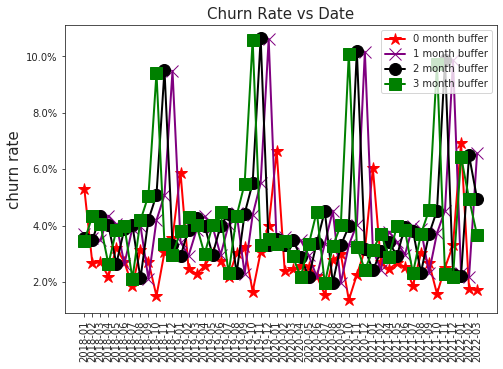

In [121]:
churn_year_0_hist_3=df_buffer_0_hist_3.groupby(['year','month']).mean().reset_index().loc[:,["year","month","churn"]]
churn_year_0_hist_3['date']=churn_year_0_hist_3.apply(lambda row: datetime.strptime(f"{int(row.year)}-{int(row.month)}", '%Y-%m').strftime("%Y-%m"), axis=1)
# churn_year_0_hist_3.style.format({"churn":"{.2%}"})
churn_year_1_hist_3=df_buffer_1_hist_3.groupby(['year','month']).mean().reset_index().loc[:,["year","month","churn"]]
churn_year_1_hist_3['date']=churn_year_1_hist_3.apply(lambda row: datetime.strptime(f"{int(row.year)}-{int(row.month)}", '%Y-%m').strftime("%Y-%m"), axis=1)
# churn_year_1_hist_3.style.format({"churn":"{.2%}"})
churn_year_2_hist_3=df_buffer_2_hist_3.groupby(['year','month']).mean().reset_index().loc[:,["year","month","churn"]]
churn_year_2_hist_3['date']=churn_year_2_hist_3.apply(lambda row: datetime.strptime(f"{int(row.year)}-{int(row.month)}", '%Y-%m').strftime("%Y-%m"), axis=1)
# churn_year_2_hist_3.style.format({"churn":"{.2%}a"})
churn_year_3_hist_3=df_buffer_3_hist_3.groupby(['year','month']).mean().reset_index().loc[:,["year","month","churn"]]
churn_year_3_hist_3['date']=churn_year_3_hist_3.apply(lambda row: datetime.strptime(f"{int(row.year)}-{int(row.month)}", '%Y-%m').strftime("%Y-%m"), axis=1)
# churn_year_3_hist_3.style.format({"churn":"{.2%}"})

plt.figure(figsize=(10,8))
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1]) # main axes

ax.plot(churn_year_0_hist_3["date"][:-2],churn_year_0_hist_3["churn"][:-2],color="r",marker="*",linewidth=2, markersize=12,label="0 month buffer")
ax.plot(churn_year_1_hist_3["date"][:-2],churn_year_1_hist_3["churn"][:-2],color="purple",marker="x",linewidth=2, markersize=12,label="1 month buffer")
ax.plot(churn_year_2_hist_3["date"][:-2],churn_year_2_hist_3["churn"][:-2],color="black",marker="o",linewidth=2, markersize=12,label="2 month buffer")
ax.plot(churn_year_3_hist_3["date"][:-2],churn_year_3_hist_3["churn"][:-2],color="green",marker="s",linewidth=2, markersize=12,label="3 month buffer")

ax.set_title("Churn Rate vs Date",fontsize=15)
ax.legend()
ax.set_ylabel("churn rate",fontsize=15)
# ax.set_xticks([2018,2019,2020,2021,2022])
# ax.set_ylim([0,0.1])
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.1%}'.format(x) for x in vals])
for item in ax.get_xticklabels():
    item.set_rotation(90)
plt.show()